## Bayesian rate consistency model with PriorVAE


In [28]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.cm import coolwarm
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
numpyro.set_host_device_count(4)
numpyro.enable_x64()

import jax
import optax
from jax import random
import jax.numpy as jnp
import pyreadr
import pandas as pd
import os
from flax import linen as nn
import arviz as az

from priorCVAE.models import MLPDecoder
from priorCVAE.priors import Matern32, Matern52, SquaredExponential
from priorCVAE.datasets import GPDataset
from priorCVAE.utility import load_model_params

from bayes_rate_consistency.model import simulation_model_gp, simulation_model_vae
from bayes_rate_consistency.mcmc import run_mcmc
from bayes_rate_consistency.simulation import load_simulated_dataset, sim_make_mcmc_data, simulation_inference, simulation_postprocess
from bayes_rate_consistency.simulation import sim_posterior_predictive_check

import jax.config as config
config.update("jax_enable_x64", True)

In [29]:
# Configuration dictionary
args = {
        "n_data": 44,
        "batch_size": 500,
        "num_iterations": 5000,
        "data_dim": 2,

        "input_dim" : 1936,
        "hidden_dim1": 1700,
        "hidden_dim2": 1000,
        "hidden_dim3": 800,
        "hidden_dim4": 400,
        "latent_dim": 50,

        "n_test": 5000,
        "kernel": "matern52",
        "ls": 0.2
       }

# # Configuration dictionary
# args = {
#         "n_data": 25,
#         "batch_size": 500,
#         "num_iterations": 5000,
#         "data_dim": 2,

#         "input_dim" : 625,
#         "hidden_dim1": 500,
#         "hidden_dim2": 300,
#         "hidden_dim3": 100,
#         "latent_dim": 30,

#         "n_test": 5000,
#         "kernel": "matern52",
#         "ls": 0.2
#        }

In [30]:
args['model_path'] = "weights/model_large_9000_mat52_0.2"
args['model_path'] = "weights/model_large_12000_2000_mat52_0.1"

## Generate data

In [31]:
kernel = Matern52(lengthscale=0.2)

gp_set = GPDataset(n_data=args["n_data"], kernel=kernel, sample_lengthscale=False, x_dim=2)  
# sample_x_train, sample_y_train, sample_ls_train = gp_set.simulatedata(n_samples=args['batch_size'])
x_test, y_test, ls_test = gp_set.simulatedata(n_samples=1)

## Load the model


In [32]:
decoder_params = load_model_params(args["model_path"])["decoder"]
decoder_params['dec_hidden_0']['bias'].shape

(800,)

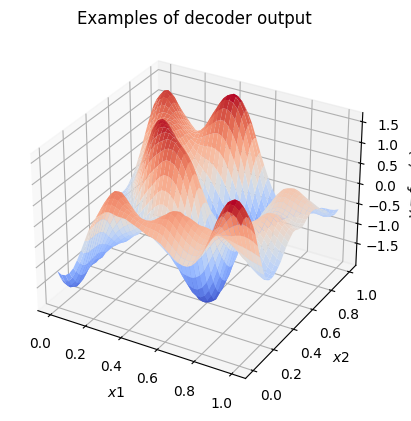

In [33]:
# from bayes_rate_consistency.decoder import MLPDecoder

# decoder = MLPDecoder(args["hidden_dim"], args["input_dim"])
decoder = MLPDecoder([args["hidden_dim3"], args["hidden_dim2"], args["hidden_dim1"]], args["input_dim"], nn.gelu)

key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (args["n_test"], args["latent_dim"]))

key = jax.random.PRNGKey(rnd.randint(0, 9999))
key, e_rng, d_rng = jax.random.split(key, 3)

vae_samples = decoder.apply({'params': decoder_params}, z)             


vae_samples_reshaped = vae_samples.reshape((args["n_test"], gp_set.n_data, gp_set.n_data))

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d"})

x = jnp.linspace(0, 1, args['n_data'])
x1, x2 = jnp.meshgrid(x, x)
ax.plot_surface(x1, x2, vae_samples_reshaped[50], cmap=coolwarm)

ax.set_xlabel('$x1$')
ax.set_ylabel('$x2$')
ax.set_zlabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of decoder output')

plt.show()

## Bayesian rate consistency model

#### Load Data

In [34]:
A = 44 # number of ages
size = 5000
strata_scheme = 'COVIMOD'
intensity = 'inCOVID'


data = load_simulated_dataset(
    project_root='./',
    intensity=intensity,
    size=size,
    strata=strata_scheme
)

In [35]:
mcmc_data = sim_make_mcmc_data(data, strata_scheme, A)

#### Plot contact counts

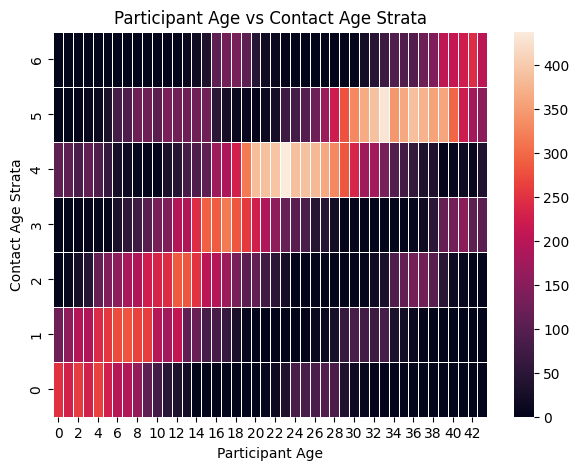

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))  # Set the figure size
sns.heatmap(mcmc_data['Y_MM'].T, annot=False, fmt="d", linewidths=.5)

plt.title('Participant Age vs Contact Age Strata')
plt.xlabel('Participant Age')
plt.ylabel('Contact Age Strata')

plt.gca().invert_yaxis()

# Display the plot
plt.show()


#### MCMC Inference

In [37]:
model = simulation_model_vae

In [38]:

args = {
        # # decoder architecture
        # "input_dim" : 1936,
        # "hidden_dim": 80,
        # "latent_dim": 30,
        "z_dim": 50,

        # MCMC inference
        "num_warmup": 500,
        "num_samples": 1000,
        "num_chains": 4,
        "thinning": 1,
       }

In [39]:
args['logP'] = mcmc_data['log_P_M']
args['logN'] = mcmc_data['log_N_M']

args['map_age_to_strata'] = mcmc_data['map_age_to_strata']

# 1e-13

In [40]:
args['decoder'] = decoder
args['decoder_params'] = decoder_params

In [41]:
x = gp_set.x
args['kernel'] = Matern52(0.1)(x,x)
args['size'] = x.shape[0]

In [42]:
numpyro.enable_validation()
rng_key = random.PRNGKey(1)
rng_key, rng_key_post, rng_key_predict, rng_key_draw = jax.random.split(rng_key, 4)

mcmc, mcmc_samples, t_elapsed = run_mcmc(rng_key_post, model, args, y=mcmc_data['Y_MM'])

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [43]:
predictive = Predictive(model, mcmc_samples.copy())
predictions = predictive(rng_key_predict, args)

In [44]:
inference_data = az.from_numpyro(mcmc, posterior_predictive=predictions)
# inference_data
# az.ess(inference_data.posterior, relative=True).values

In [45]:
inference_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [46]:
mcmc_samples['alpha'].shape

(4000, 44, 7)

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

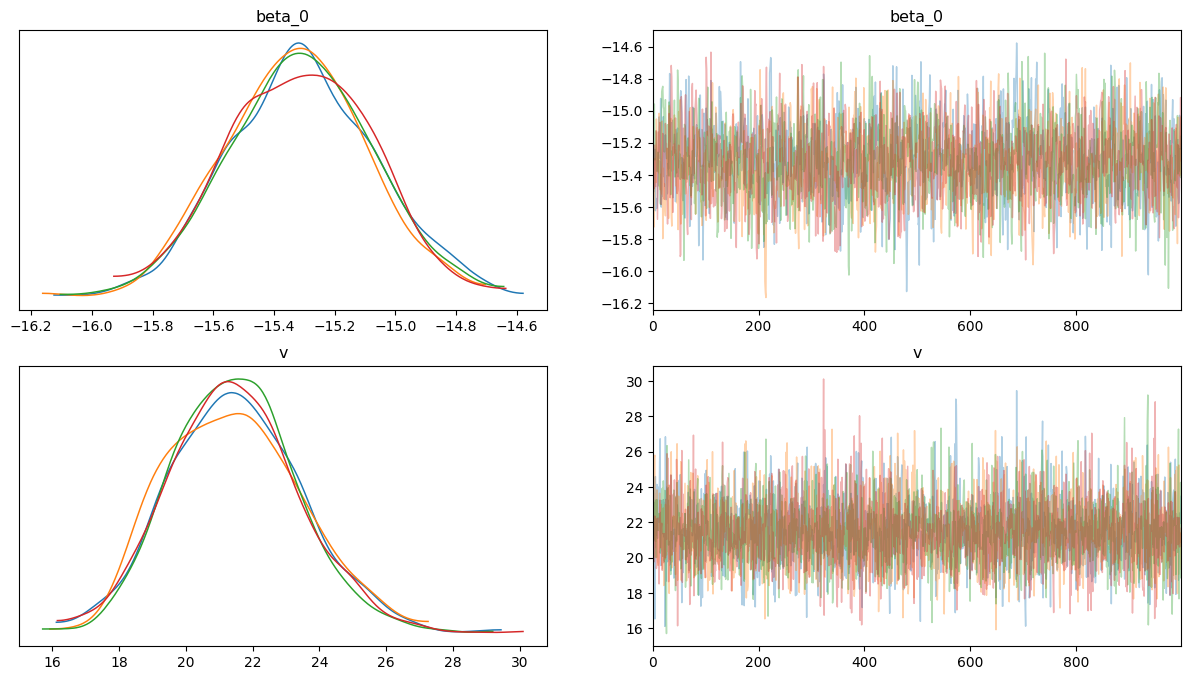

In [47]:
az.plot_trace(mcmc, var_names = ("beta_0", "v"), figsize = (15, 8), compact = False)

#### Posterior predictive checks

In [48]:
y_strata = mcmc_data['Y_MM']
y_check = sim_posterior_predictive_check(y_strata, inference_data.posterior_predictive['yhat_strata'])
print(f"Proportion of y in 95% CI: {y_check:.5f}")



Proportion of y in 95% CI: 0.98052


In [49]:
yhat_strata = inference_data.posterior_predictive.median(dim=["chain", "draw"])['yhat_strata'].values
np.mean(np.abs(yhat_strata-y_strata))

25.941558441558442

#### Recover contact intensities

In [50]:
P = mcmc_data['P_M']
P = np.tile(P, (44, 1))

m_pred = jnp.exp(inference_data.posterior_predictive.median(dim=["chain", "draw"])['log_contact_rate'].values).reshape(44,44) * P

In [51]:
m = data[
    (data['gender'] == 'Male') & 
    (data['alter_gender'] == 'Male')
].sort_values(by=['age', 'alter_age']).cntct_intensity.to_numpy().reshape(44,44)

In [52]:
mae = np.mean(np.abs(m - m_pred))
mae

0.1007059707322104

In [53]:
import plotly.graph_objects as go

def plot_heatmap(matrix, title='', color_scale="Magma"):
    """ Plot a heatmap of the input matrix using Plotly. """
    fig = go.Figure(data=go.Heatmap(z=matrix, colorscale=color_scale, zmin=0,
        zmax=None, 
        xgap=0.1, 
        ygap=0.1 ))
    fig.update_layout(
        title=title, autosize=False, width=500, height=500,
        title_x=0.5,  # This centers the title
        xaxis_showgrid=True,
        yaxis_showgrid=True,
        xaxis_gridcolor='white',
        yaxis_gridcolor='white')

    return fig

plot_heatmap(y_strata.T, "Simulated intensities").show()

In [54]:
import plotly.graph_objects as go

def plot_heatmap(matrix, title='', color_scale="Turbo"):
    """ Plot a heatmap of the input matrix using Plotly. """
    line_options = dict(width=0.5, color='white')
    fig = go.Figure(data=go.Heatmap(z=matrix, colorscale=color_scale, zmin=0,
        zmax=2, 
        xgap=0.1, 
        ygap=0.1 ))
    fig.update_layout(
        title=title, autosize=False, width=500, height=500,
        title_x=0.5,  # This centers the title
        xaxis_showgrid=True,
        yaxis_showgrid=True,
        xaxis_gridcolor='white',
        yaxis_gridcolor='white')

    return fig

plot_heatmap(m_pred.T, "Simulated intensities").show()